In [2]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Polygon


import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from mitequinox.utils import *
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.137:52683 Dashboard: http://10.148.0.137:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load dataframe

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['mean_interp'])
df = p.df['mean_interp']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [5]:
df_uv = df.drop(columns=[c for c in df.columns[6:9].append(df.columns[11:15]).values]) #drop sea level, temperature and salinity
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,SSU_interp,SSV_interp
npartitions=747,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [6]:
df_uv = df_uv.rename(columns={'SSU_interp':'zonal_velocity_interp','SSV_interp':'meridional_velocity_interp'})#.persist()

In [7]:
columns = ['zonal_velocity','meridional_velocity']
for V in columns:
    df_uv[V+'_prime'] = df_uv[V].sub(df_uv[V+'_interp'])
#df_uv = df_uv.persist()

In [8]:
df_uv['velocity_amplitude'] = np.sqrt(df_uv['zonal_velocity']**2+df_uv['meridional_velocity']**2)
df_uv['velocity_amplitude_interp'] = np.sqrt(df_uv['zonal_velocity_interp']**2+df_uv['meridional_velocity_interp']**2)
df_uv['velocity_amplitude_prime'] = np.sqrt(df_uv['zonal_velocity_prime']**2+df_uv['meridional_velocity_prime']**2)

In [9]:
df_uv = df_uv.persist()

### Binned mean flows : 

In [10]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [11]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)


In [12]:
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)


In [13]:
df_bin_mean = p.load_diagnostic('L_mean_std.zarr')

In [15]:
df_bin_mean.load()

<xarray.Dataset>
Dimensions:                   (lat: 179, lon: 359)
Coordinates:
  * lat                       (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables: (12/14)
    area_mean                 (lon, lat) float64 nan 49.22 28.8 ... 28.8 49.22
    area_std                  (lon, lat) float64 nan 49.22 28.8 ... 28.8 49.22
    meridional_velocity_mean  (lon, lat) float64 nan nan nan nan ... nan nan nan
    meridional_velocity_std   (lon, lat) float64 nan nan nan nan ... nan nan nan
    salinity_mean             (lon, lat) float64 nan nan nan nan ... nan nan nan
    salinity_std              (lon, lat) float64 nan nan nan nan ... nan nan nan
    ...                        ...
    temperature_mean          (lon, lat) float64 nan nan nan nan ... nan nan nan
    temperature_std           (lon, lat) float64 nan nan nan nan ... nan nan nan
    velocity_amplitude_mean   (lon, lat) float64 nan nan nan nan ... nan nan nan
    velocity_amplitude_std    (lon, lat) float64 nan nan nan nan ... nan nan nan
    zonal_velocity_mean       (lon, lat) float64 nan nan nan nan ... nan nan nan
    zonal_velocity_std        (lon, lat) float64 nan nan nan nan ... nan nan nan

In [100]:
def myfunc(df,ds_mean,V):
    df['lon_mid'] = df.lon_cut.apply(lambda r: r.mid)
    df['lat_mid'] = df.lat_cut.apply(lambda r: r.mid)
    mean_val = ds_mean[V+'_mean'].sel(lat=np.unique(df.lat_mid.values),lon=np.unique(df.lon_mid.values))
    df[V+'_sub'] = df[V]-mean_val.values[0]
    df = df.drop(columns=['lon_mid','lat_mid'])
    return df

In [101]:
df_uv = df_uv.groupby(['lon_cut','lat_cut']).apply(myfunc,df_bin_mean,'zonal_velocity')
df_uv = df_uv.groupby(['lon_cut','lat_cut']).apply(myfunc,df_bin_mean,'meridional_velocity')

<ipython-input-101-5e5257e1f18c>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_uv = df_uv.groupby(['lon_cut','lat_cut']).apply(myfunc,df_bin_mean,'zonal_velocity')
<ipython-input-101-5e5257e1f18c>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_uv = df_uv.groupby(['lon_cut','lat_cut']).apply(myfunc,df_bin_mean,'meridional_velocity')


In [102]:
df_uv = df_uv.persist()

In [14]:
df_mean = df_uv.groupby([df_uv.lon_cut, df_uv.lat_cut]).mean().compute()

df_mean = add_geodata(df_mean)
#count['density'] = count['count']/count['area']

df_mean = (df_mean
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [15]:
df_mean

<xarray.Dataset>
Dimensions:                     (lat: 179, lon: 359)
Coordinates:
  * lon                         (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                         (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
Data variables:
    trajectory                  (lon, lat) float64 nan nan nan ... nan nan nan
    z                           (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity              (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity         (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_interp       (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_interp  (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime        (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime   (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude          (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_interp   (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_prime    (lon, lat) float64 nan nan nan ... nan nan nan
    area                        (lon, lat) float64 nan 49.22 28.8 ... 28.8 49.22

#### Lagrangian raw velocity, u : 

In [23]:
df_mean['zonal_velocity']

<xarray.DataArray 'zonal_velocity' (lon: 359, lat: 179)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5

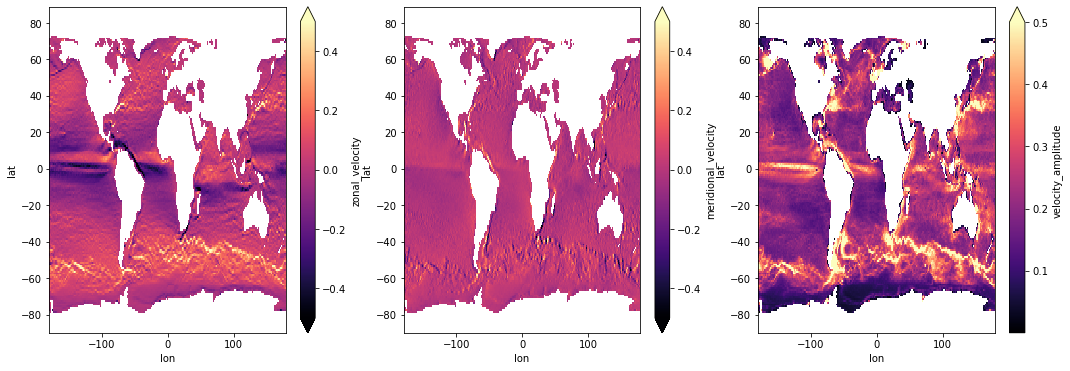

In [41]:
#projection = ccrs.ccrs.PlateCarree()
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')
  #  ax.coastlines()
#ax.set_aspect('equal')

#### Total velocity minus binned Lagrangian mean, $u'_b$ : 

In [65]:
df_uv.zonal_velocity.groupby([df_uv.lon_cut, df_uv.lat_cut]).sub(df_bin_mean.zonal_velocity_mean)

AttributeError: 'SeriesGroupBy' object has no attribute 'sub'

In [63]:
df_bin_mean.zonal_velocity_mean


<xarray.DataArray 'zonal_velocity_mean' (lon: 359, lat: 179)>
dask.array<xarray-zonal_velocity_mean, shape=(359, 179), dtype=float64, chunksize=(180, 179), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5

#### Total velocity minus interpolated Eulerian mean, $u'_i$ : 

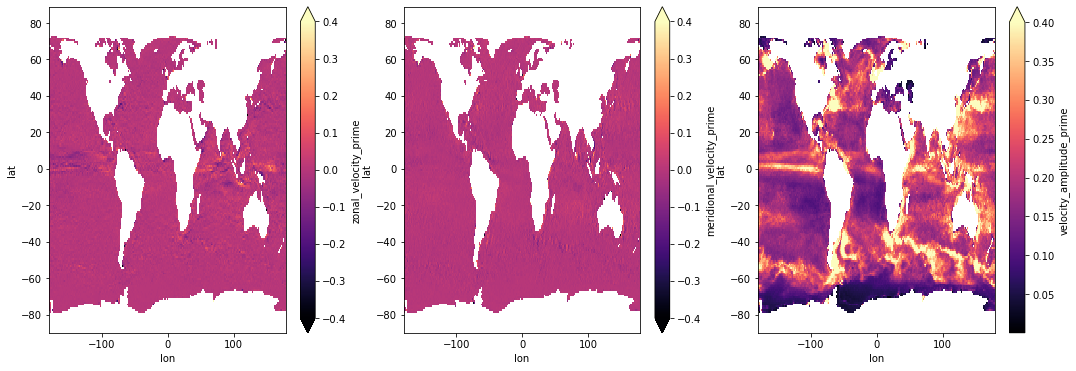

In [45]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')

### Variance and EKE : 

In [16]:
df_uv_sq = df_uv.copy()

In [18]:
for V in df_uv_sq.columns[4:-2]:
    df_uv_sq[V] = df_uv[V]**2

In [19]:
df_uv_sq = df_uv_sq.persist()

In [20]:
df_mean_sq = df_uv_sq.groupby([df_uv_sq.lon_cut, df_uv_sq.lat_cut]).mean().compute()

df_mean_sq = add_geodata(df_mean_sq)
#count['density'] = count['count']/count['area']

df_mean_sq = (df_mean_sq
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

#### Variance : 

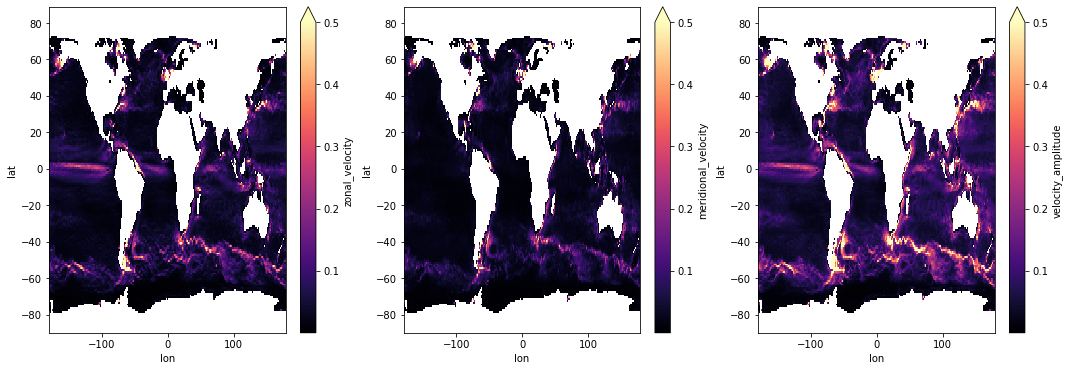

In [22]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean_sq[V].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')

#### EKE : $<u_b'^2>$ and $<u_i'^2>$

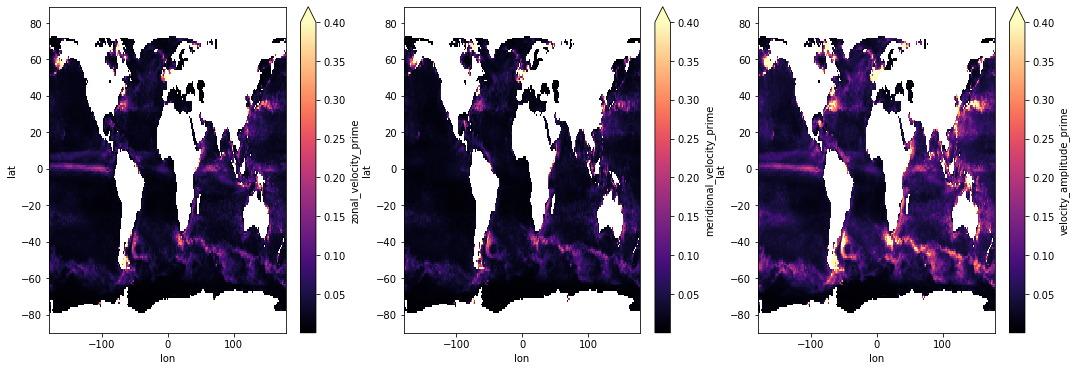

In [24]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean_sq[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')

In [ ]:
cluster.close()